In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import utils

import os
import nibabel as nib
import copy

import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
channels = 4
resize_shape = (144,144,144)

# Data

In [4]:
# MRI directory
# '../../data/data/mri/MICCAI_BraTS2020_TrainingData/'
image_dir = '../../glioma_mtl/data/all_brats_scans/'

In [5]:
# I fed in samples by IDs (because I was attaching metadata to them; this is not necessary)
glioma_metadata_df = pd.read_csv('../data/glioma_metadata.csv', index_col=0) # metadata file
glioma_metadata_df = glioma_metadata_df.loc[glioma_metadata_df['phase'].isin(['train', 'val'])]

# Transformations

In [6]:
import random
import skimage.transform as skTrans

class ScaleToFixed(object):

    def __init__(self, new_shape, interpolation=1, channels=4):
        self.shape= new_shape
        self.interpolation = interpolation
        self.channels = channels

    def __call__(self, image):
        # print('first shape', image.shape)
        if image is not None: # (some patients don't have segmentations)
            if self.channels == 1:
                short_shape = (self.shape[1], self.shape[2], self.shape[3])
                image = skTrans.resize(image, short_shape, order=self.interpolation, preserve_range=True)  #
                image = image.reshape(self.shape)
            else:
                image = skTrans.resize(image, self.shape, order=self.interpolation, preserve_range=True)  #

        # print('second shape', image.shape)
        # print()
        return image


class MinMaxNormalize(object):
    """Min-Max normalization
    """
    def __call__(self, image):
        def norm(im):
            im = im.astype(np.float32)
            min_v = np.min(im)
            max_v = np.max(im)
            im = (im - min_v)/(max_v - min_v)
            return im
        image = norm(image)
        return image

class ToTensor(object):
    def __init__(self, scale=1):
        self.scale = scale

    def __call__(self, image):
        if image is not None:
            image = image.astype(np.float32)
            image = image.reshape((image.shape[0], int(image.shape[1]/self.scale), int(image.shape[2]/self.scale), int(image.shape[3]/self.scale)))
            image_tensor = torch.from_numpy(image)
            return image_tensor
        else:
            return image


class Compose(object):
    """
    Composes several transforms together.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for i, t in enumerate(self.transforms):
            image = t(image)
        return image

In [7]:
# MRI transformations
train_transformations = Compose([
    MinMaxNormalize(),
    ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]),
                          interpolation=1,
                          channels=channels),
    ToTensor()
])

seg_transformations = Compose([
            ScaleToFixed((1, resize_shape[0],resize_shape[1],resize_shape[2]),
                                      interpolation=0,
                                      channels=1),
            ToTensor(),
        ])

# Dataloader

In [8]:
def get_bb_3D(img, pad=0):
    '''
    This function returns a tumor 3D bounding box using a segmentation mask
    '''
    xs = np.nonzero(np.sum(np.sum(img, axis=1), axis=1))
    ys = np.nonzero(np.sum(np.sum(img, axis=0), axis=1))
    zs = np.nonzero(np.sum(np.sum(img, axis=0), axis=0))
    xmin, xmax = np.min(xs), np.max(xs)
    ymin, ymax = np.min(ys), np.max(ys)
    zmin, zmax = np.min(zs), np.max(zs)
    bbox = (xmin-pad, ymin-pad, zmin-pad, xmax+pad, ymax+pad, zmax+pad)
    return bbox

def min_max(img):
    '''
    Min-max normalization
    '''
    return (img - img.min()) / (img.max() - img.min())

def read_mri(mr_path_dict, pad=0, get_bb=True, bb_modality='flair'):
    if get_bb:
        # to crop to brain edge, give it a standard modality; to get tumor bb, give it segmenation mask
        mri_image = nib.load(mr_path_dict[bb_modality]).get_fdata()


        # get bounding box around tumor
        bb_seg = get_bb_3D(mri_image)

        (xmin, ymin, zmin, xmax, ymax, zmax) = bb_seg

        xmin = np.max([0, xmin-pad])
        ymin = np.max([0, ymin-pad])
        zmin = np.max([0, zmin-pad])

        xmax = np.min([mri_image.shape[0]-1, xmax+pad])
        ymax = np.min([mri_image.shape[1]-1, ymax+pad])
        zmax = np.min([mri_image.shape[2]-1, zmax+pad])
    else:
        xmin, ymin, zmin = 0, 0, 0
        
        mri_image = nib.load(mr_path_dict[bb_modality]).get_fdata()
        xmax, ymax, zmax = mri_image.shape

    img_dict = {}
    for key in ['flair', 't1', 't1ce', 't2', 'seg']:
        img_data = nib.load(mr_path_dict[key]).get_fdata()
        img_dict[key] = img_data[xmin:xmax, ymin:ymax, zmin:zmax]

    # normalize each modality separately
    stacked_img = np.stack([min_max(img_dict['flair']), 
                            min_max(img_dict['t1']),
                            min_max(img_dict['t1ce']),
                            min_max(img_dict['t2'])], 
                           axis=0)
    return stacked_img, img_dict['seg']

In [9]:
from torch.utils.data import Dataset
class GeneralDataset(Dataset):

    def __init__(self,
                 metadata_df,
                 root_dir,
                 transform=None,
                 seg_transform=None,
                 pad=2,
                 get_bb=True,
                 device='cpu'):
        """
        Args:
            metadata_df (string): Path to the csv file w/ patient IDs
            root_dir (string): Directory for MRI images
            transform (callable, optional)
            seg_transform (callable, optional)
            pad: pad bounding box
            get_bb: return cropped mri image (either of the brain or of the tumor)
        """
        self.metadata_df = metadata_df
        self.root_dir = root_dir
        self.transform = transform
        self.seg_transform = seg_transform
        self.pad = pad
        self.get_bb = get_bb
        self.device=device


    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # "name" of patient
        BraTS18ID = self.metadata_df.iloc[idx].name

        # make dictonary of paths to MRI volumes (modalities) and segmenation masks
        mr_path_dict = {}
        sequence_type = ['seg', 't1', 't1ce', 'flair', 't2']
        for seq in sequence_type:
            mr_path_dict[seq] = os.path.join(self.root_dir, BraTS18ID, BraTS18ID + '_'+seq+'.nii.gz')

        # get mri data
        image, seg_image = read_mri(mr_path_dict=mr_path_dict, pad=self.pad, get_bb=self.get_bb)

        # binarize the segmentation mask
        if seg_image is not None:
#             seg_image[seg_image == 4] = 3
            seg_image[seg_image != 0] = 1

        if self.transform:
            image = self.transform(image)
        if self.seg_transform:
            seg_image = self.seg_transform(seg_image)
 
        return (image, seg_image), BraTS18ID

In [10]:
transformed_dataset_train = GeneralDataset(metadata_df=glioma_metadata_df, 
                                           root_dir=image_dir,
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           get_bb=False) # toggle to crop to the edge of the brain

In [11]:
train_batch_size = 4
dataloader_train = DataLoader(transformed_dataset_train, batch_size=train_batch_size, shuffle=True, num_workers=4)

# Visualize data (from dataloader)

In [12]:
def visualize_mri_data(image, seg_image, bratsID):
    print('First BraTS MRI:')
    print('\t', bratsID[0])
    print('\t', image.shape)

    img = image[0,:, :, :, int(image.shape[-1]/2)].squeeze()
    img = utils.make_grid(img)
    img = img.detach().cpu().numpy()
    
    # plot images
    plt.figure(figsize=(15, 8))
    img_list = [img[i].T for i in range(channels)] # 1 image per channel
    plt.imshow(np.hstack(img_list), cmap='Greys_r')
    plt.show()
    
    print('Segmentation Mask:')
    ## plot segmentation mask ##
    seg_img = seg_image[0, :, :, :, int(seg_image.shape[-1]/2)].squeeze()
    seg_img = utils.make_grid(seg_img).detach().cpu().numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r')
    plt.show()

First BraTS MRI:
	 Brats18_TCIA04_212_1
	 torch.Size([4, 4, 144, 144, 144])


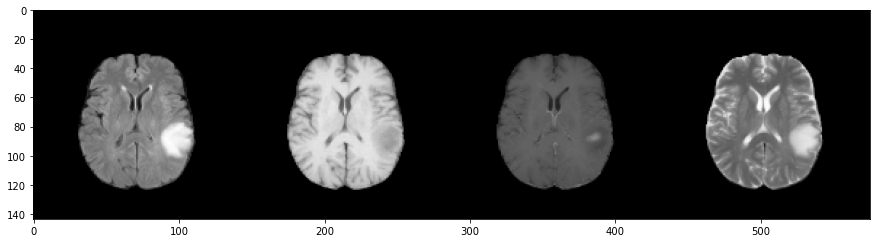

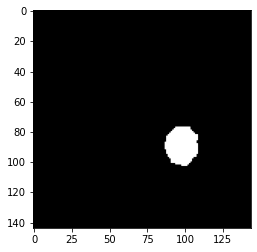

In [13]:
# visualize training (or validation) data
for i, data in enumerate(dataloader_train):
    
    (image, seg_image), bratsID = data
    
    visualize_mri_data(image=image, seg_image=seg_image, bratsID=bratsID)
    
    break